# Simulate model objects and brain objects

As mentioned in the previous tutorials, you can also simulate data. You can simulate brain objects or you can simulate a list of brain objects to create a model. In this tutorial, we will walk you through the simulate functions and explore varying parameters.

# Load in the required libraries

In [1]:
%matplotlib inline
import supereeg as se
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from supereeg.helpers import _corr_column
%load_ext autoreload
%autoreload 2

# Simulate locations

To begin, we can either simulate locations:

In [2]:
sim_locs = se.simulate_locations()
sim_locs.head()

,x,y,z
0,-27,12,15
1,-26,43,-47
2,-23,-42,-44
3,-19,0,30
4,-6,35,29


# Simulate brain object

## simulate_bo()

By default, the simualate_bo function will return a 1000 samples by 10 electrodes matrix, but you can specify the number of time samples with n_samples, sessions with sessions, and the number of electrodes with n_elecs or by passing specific electrodes with locs.

In [3]:
# simulate brain object with example locations
bo = se.simulate_bo(n_samples=1000, sample_rate=100, sessions=2)

You can view your simulated data with bo.plot_data and simulated locations with bo.plot_locs.

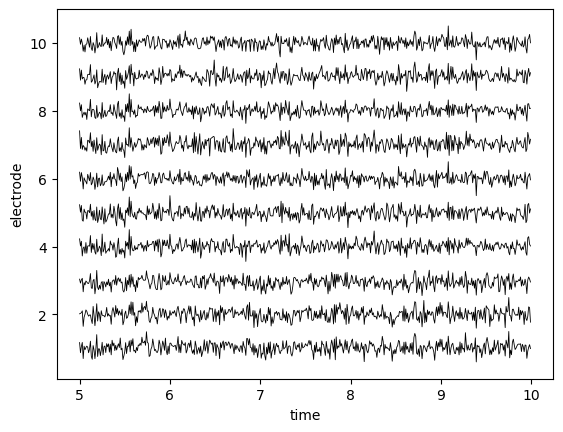

In [4]:
# for plotting data, the default time window is first 10 seconds, but you can specifiy your own window
bo.plot_data(time_min=5, time_max=10)

# close plot
plt.close()

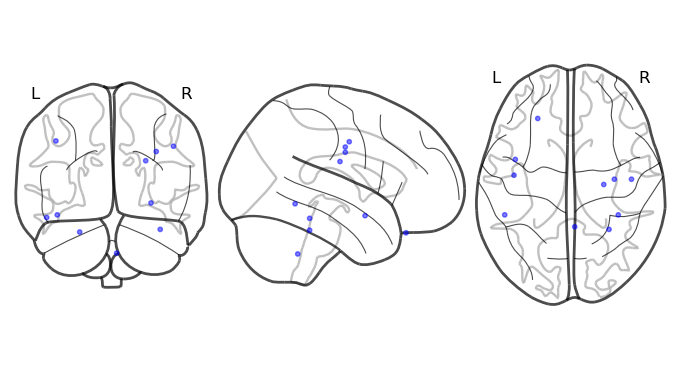

In [5]:
# plot locations
bo.plot_locs()

# Replicating simulated data with a random seed

We’ve added a random_seed=False and noise=.1 parameters as defaults. But if you want to recreate the same brain object, you can set these flags to: random_seed=True and noise=0

In [6]:
# if you want to simulate the same brain object again
bo_1 = se.simulate_bo(n_samples=1000, sessions=2, n_elecs=5, random_seed=True, noise=0).get_data()
bo_2 = se.simulate_bo(n_samples=1000, sessions=2, n_elecs=5, random_seed=True, noise=0).get_data()
np.allclose(bo_1, bo_2)

True

# Specify correlation matrix to generate simulated data

We use a correlation matrix to impose on the simulated subject data. The default is random uses a positive semi-definite matrix created using random seed. In this example we use cov='toeplitz' but options include:

'toeplitz' - toeplitz matrix

'eye' - identity matrix

'distance' - distance matrix

'random' - positive semi-definite random matrix

In [7]:
# simulate more locations
locs = se.simulate_locations(n_elecs=100)

# create brain object with specified correlation matrix
bo = se.simulate_bo(n_samples=100, sample_rate=1000, locs=locs, cov='toeplitz')

You can also pass a custom covariance matrix in cov.

In [8]:
# create correlation matrix
R = se.create_cov(cov='toeplitz', n_elecs=len(locs))

# and use it to create a brain object
bo = se.simulate_bo(n_samples=100, sample_rate=1000, locs=locs, cov=R)

# Simulate model object

## simulate_model_bos()

You can create a simulated model object by passing a list of simulated brain objects.

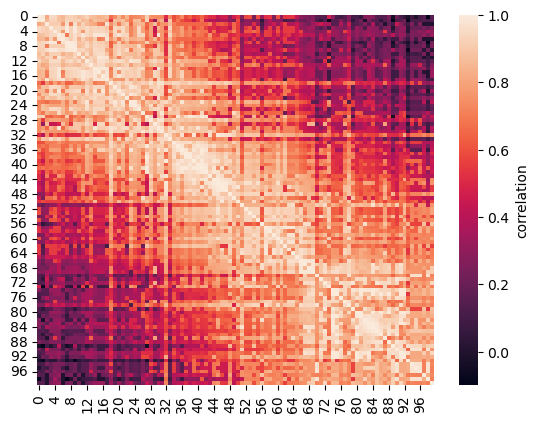

In [9]:
# number of subjects
n_sub = 5

# list of 5 simulated brain objects, each with 20 locations, for model
model_bos = [se.simulate_model_bos(n_samples=100, sample_rate=1000, sample_locs=20,
                                   locs=locs, cov=R) for x in range(n_sub)]

# create model from list of brain objects
model = se.Model(data=model_bos, locs=locs)

# plot the model
model.plot_data()

# close plot
plt.close()

# Simulation Example 1:

In this example we will parametrically vary how many subjects and how many electrodes per subject are used to create the model. We loop over number of subjects and number of randomly chosen electrodes and plot the model at each iteration. As the figure shows, the more subjects and electrodes, the better then recovery of the true model.

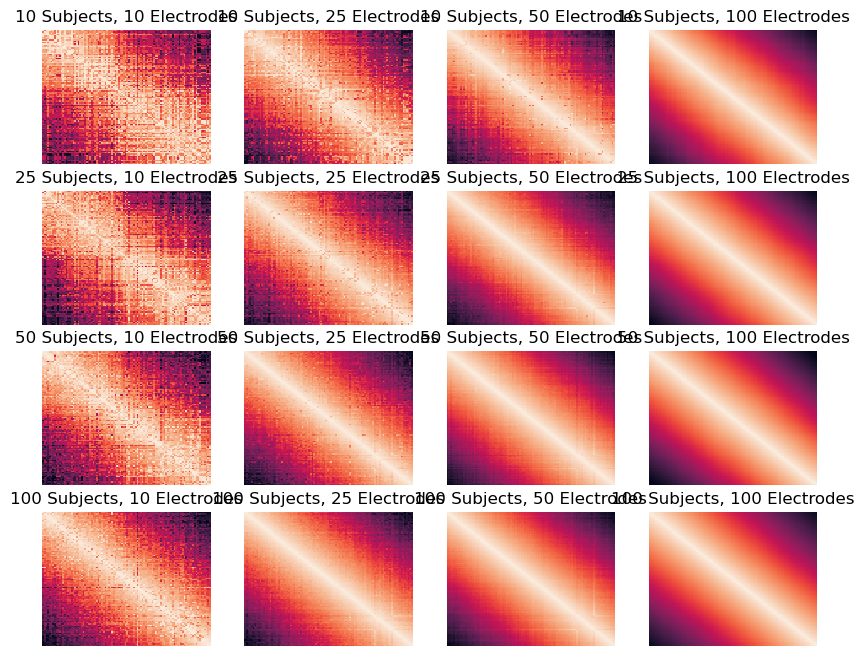

In [10]:
# n_samples
n_samples = 100

# initialize subplots
f, axarr = plt.subplots(4, 4)

f.set_size_inches(10,8)

# loop over simulated subjects size
for isub, n_subs in enumerate([10, 25, 50, 100]):
    # loop over simulated electrodes
    for ielec, n_elecs in enumerate([10, 25, 50, 100]):

        # simulate brain objects for the model
        model_bos = [se.simulate_model_bos(n_samples=n_samples, sample_rate=10, locs=locs,
                                           sample_locs=n_elecs, cov=R) for x in range(n_subs)]

        # create the model object
        model = se.Model(data=model_bos, locs=locs)

        # plot it
        model.plot_data(ax=axarr[isub, ielec], yticklabels=False,
                    xticklabels=False, cbar=False, vmin=0, vmax=1, show=False)

        # set the title
        axarr[isub, ielec].set_title(str(n_subs) + ' Subjects, ' + str(n_elecs) + ' Electrodes')


plt.show()

# close plot
plt.close()

# Simulation Example 2:

In this example, we will simulate a model and some data, and see if we can recover the model from the data.

First, we’ll load in some example locations. Then, we will simulate correlational structure (a toeplitz matrix) to impose on our simulated data. This will allow us to test whether we can recover the correlational structure in the data, and how that changes as a function of the number of subjects in the model. Then, we will simulate 10 subjects and create brain objects with their data.

The left figure shows the model derived from 10 simulated subjects. Finally, we simulate 10 additional subjects and use the model.update method to update an existing model with new data. On the right, the updated model is plotted. As is apparent from the figures, the more data in the model, the better the true correlational structure can be recovered.

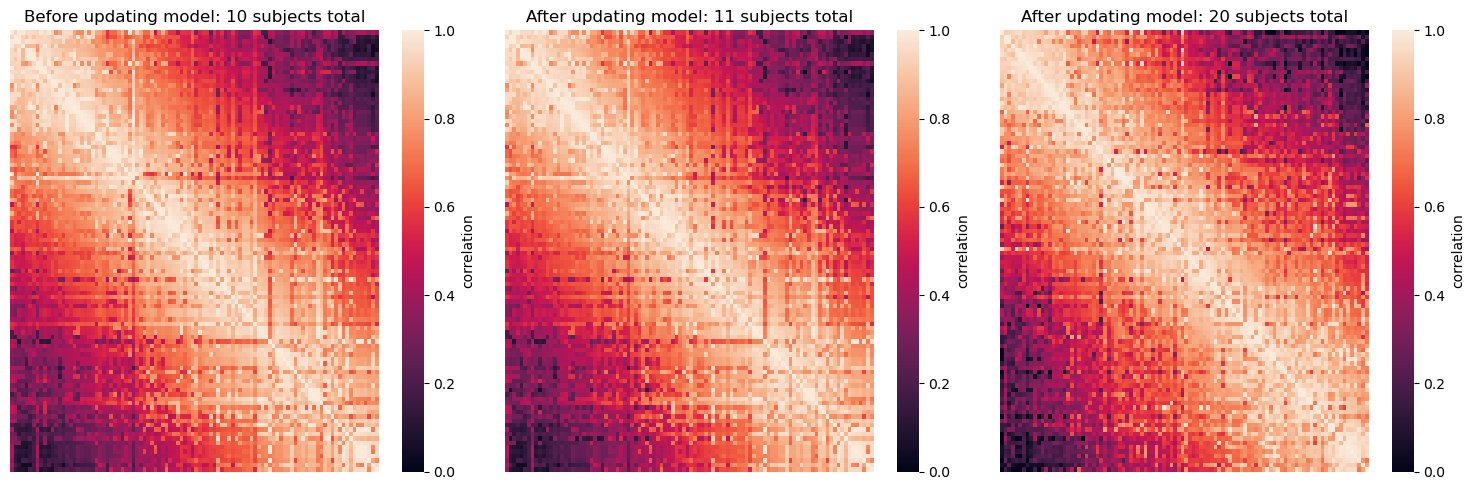

In [11]:
# number of subjects
n_subs = 10

# number of electrodes
n_elecs = 20

# simulate brain objects for the model that subsample n_elecs for each synthetic patient
model_bos = [se.simulate_model_bos(n_samples=1000, sample_rate=1000, locs=locs, sample_locs=n_elecs, cov='toeplitz') for x in
                     range(n_subs)]

# create the model object
model = se.Model(data=model_bos, locs=locs)

# brain object locations subsetted entirely from both model and gray locations - for this n > m (this isn't necessarily true, but this ensures overlap)
sub_locs = locs.sample(n_elecs).sort_values(['x', 'y', 'z'])

# simulate a new brain object using the same covariance matrix
bo = se.simulate_bo(n_samples=100, sample_rate=1000, locs=sub_locs, cov='toeplitz')

# update the model
new_model = model.update(bo, inplace=False)

# simulate brain objects for the model that subsample n_elecs for each synthetic patient
model_update_bos = [se.simulate_model_bos(n_samples=100, sample_rate=1000, locs=locs, sample_locs=n_elecs, cov='toeplitz') for y in
                     range(n_subs)]

# update the model
better_model = model.update(model_update_bos, inplace=False)

# initialize subplots
f, (ax1, ax2, ax3) = plt.subplots(1, 3)

f.set_size_inches(15,5)

# plot it and set the title
model.plot_data(ax=ax1, yticklabels=False, xticklabels=False, cbar=True, vmin=0, vmax=1, show=False)
ax1.set_title('Before updating model: 10 subjects total')
ax1.plot()


# plot it and set the title

new_model.plot_data(ax=ax2, yticklabels=False, xticklabels=False, cbar=True, vmin=0, vmax=1, show=False)
ax2.set_title('After updating model: 11 subjects total')


# plot it and set the title
better_model.plot_data(ax=ax3, yticklabels=False, xticklabels=False, cbar=True, vmin=0, vmax=1, show=False)
ax3.set_title('After updating model: 20 subjects total')

plt.tight_layout()
plt.show()

# close plot
plt.close()

# Simulation Example 3:

In this example, we will loop over 3 verying parameters:

m_patients - the number of subjects used to create the model

m_elecs - the number of electrodes per subject used to create the model

n_elecs - the number of electrodes for the reconstructed patient

As the figure shows, the more subjects and electrodes, the better then recovery of the true model.

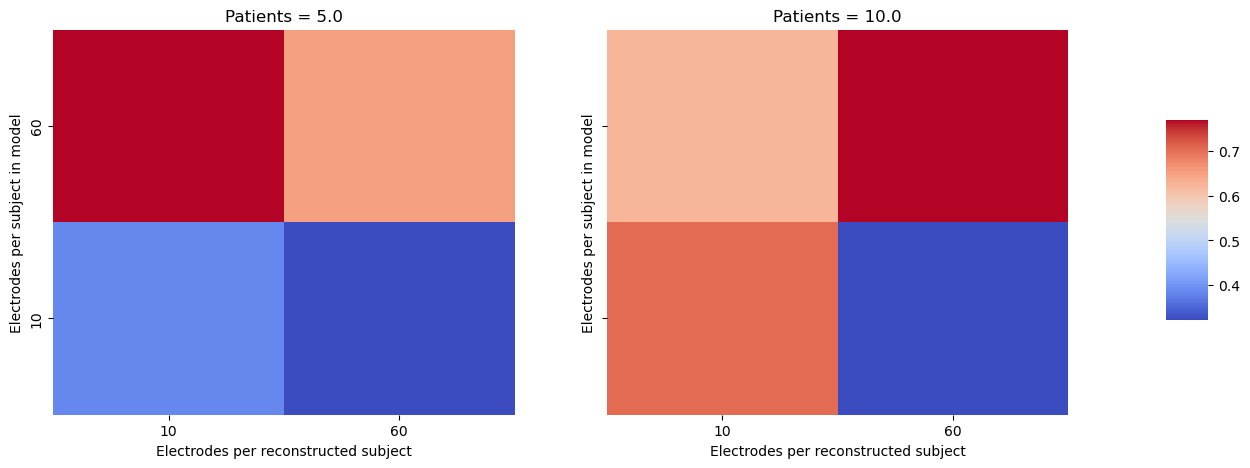

In [16]:
# n_electrodes - number of electrodes for reconstructed patient
n_elecs = range(10, 100, 50)


# m_patients - number of patients in the model
m_patients = [5, 10]


# m_electrodes - number of electrodes for each patient in the model
m_elecs = range(10, 100, 50)


iter_val = 1

append_d = pd.DataFrame()

param_grid = [(p, m, n) for p in m_patients for m in m_elecs for n in n_elecs]

for p, m, n in param_grid:
    d = []

    for i in range(iter_val):
        # create brain objects with m_patients and loop over the number of model locations and subset locations to build model
        model_bos = [se.simulate_model_bos(n_samples=100, sample_rate=1000, locs=locs, sample_locs=m, noise =.3) for x in range(p)]

        # create model from subsampled gray locations
        model = se.Model(model_bos, locs=locs)

        # brain object locations subsetted entirely from both model and gray locations
        sub_locs = locs.sample(n).sort_values(['x', 'y', 'z'])

        # simulate brain object
        bo = se.simulate_bo(n_samples=100, sample_rate=1000, locs=locs, noise =.3)

        # parse brain object to create synthetic patient data
        data = bo.data.iloc[:, sub_locs.index]

        # create synthetic patient (will compare remaining activations to predictions)
        bo_sample = se.Brain(data=data.values, locs=sub_locs)

        # reconstruct at 'unknown' locations
        bo_r = model.predict(bo_sample)

        # find the reconstructed indices
        recon_inds = np.where(np.array(bo_r.label) != 'observed')

        # sample reconstructed data a reconstructed indices
        recon = bo_r[:, recon_inds[0]]

        # sample actual data at reconstructed locations
        actual = bo[:, recon_inds[0]]

        # correlate reconstruction with actual data
        corr_vals = _corr_column(actual.get_data().values, recon.get_data().values)
        #corr_vals_sample = np.random.choice(corr_vals, 5)

        d.append(
            {'Subjects in model': p, 'Electrodes per subject in model': m, 'Electrodes per reconstructed subject': n,
             'Average Correlation': corr_vals.mean(), 'Correlations': corr_vals})

    d = pd.DataFrame(d, columns=['Subjects in model', 'Electrodes per subject in model',
                                 'Electrodes per reconstructed subject', 'Average Correlation', 'Correlations'])
    append_d = pd.concat([append_d, d])
    append_d.index.rename('Iteration', inplace=True)

new_df = append_d.groupby('Average Correlation').mean()

#fig, axs = plt.subplots(ncols=len(np.unique(new_df['Subjects in model'])), sharex=True, sharey=True)
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

axs_iter = 0

cbar_ax = fig.add_axes([.92, .3, .03, .4])

fig.subplots_adjust(right=0.85)
fig.set_size_inches(14,5)
for i in np.unique(new_df['Subjects in model']):
    data_plot = append_d[append_d['Subjects in model'] == i].pivot_table(index=['Electrodes per subject in model'],
                                                                         columns='Electrodes per reconstructed subject',
                                                                         values='Average Correlation')
    axs[axs_iter].set_title('Patients = ' + str(i))
    sns.heatmap(data_plot, cmap="coolwarm", cbar=axs_iter == 0, ax=axs[axs_iter], cbar_ax=None if axs_iter else cbar_ax)
    axs[axs_iter].invert_yaxis()
    axs_iter += 1

plt.show()

Simulations run on the cluster:

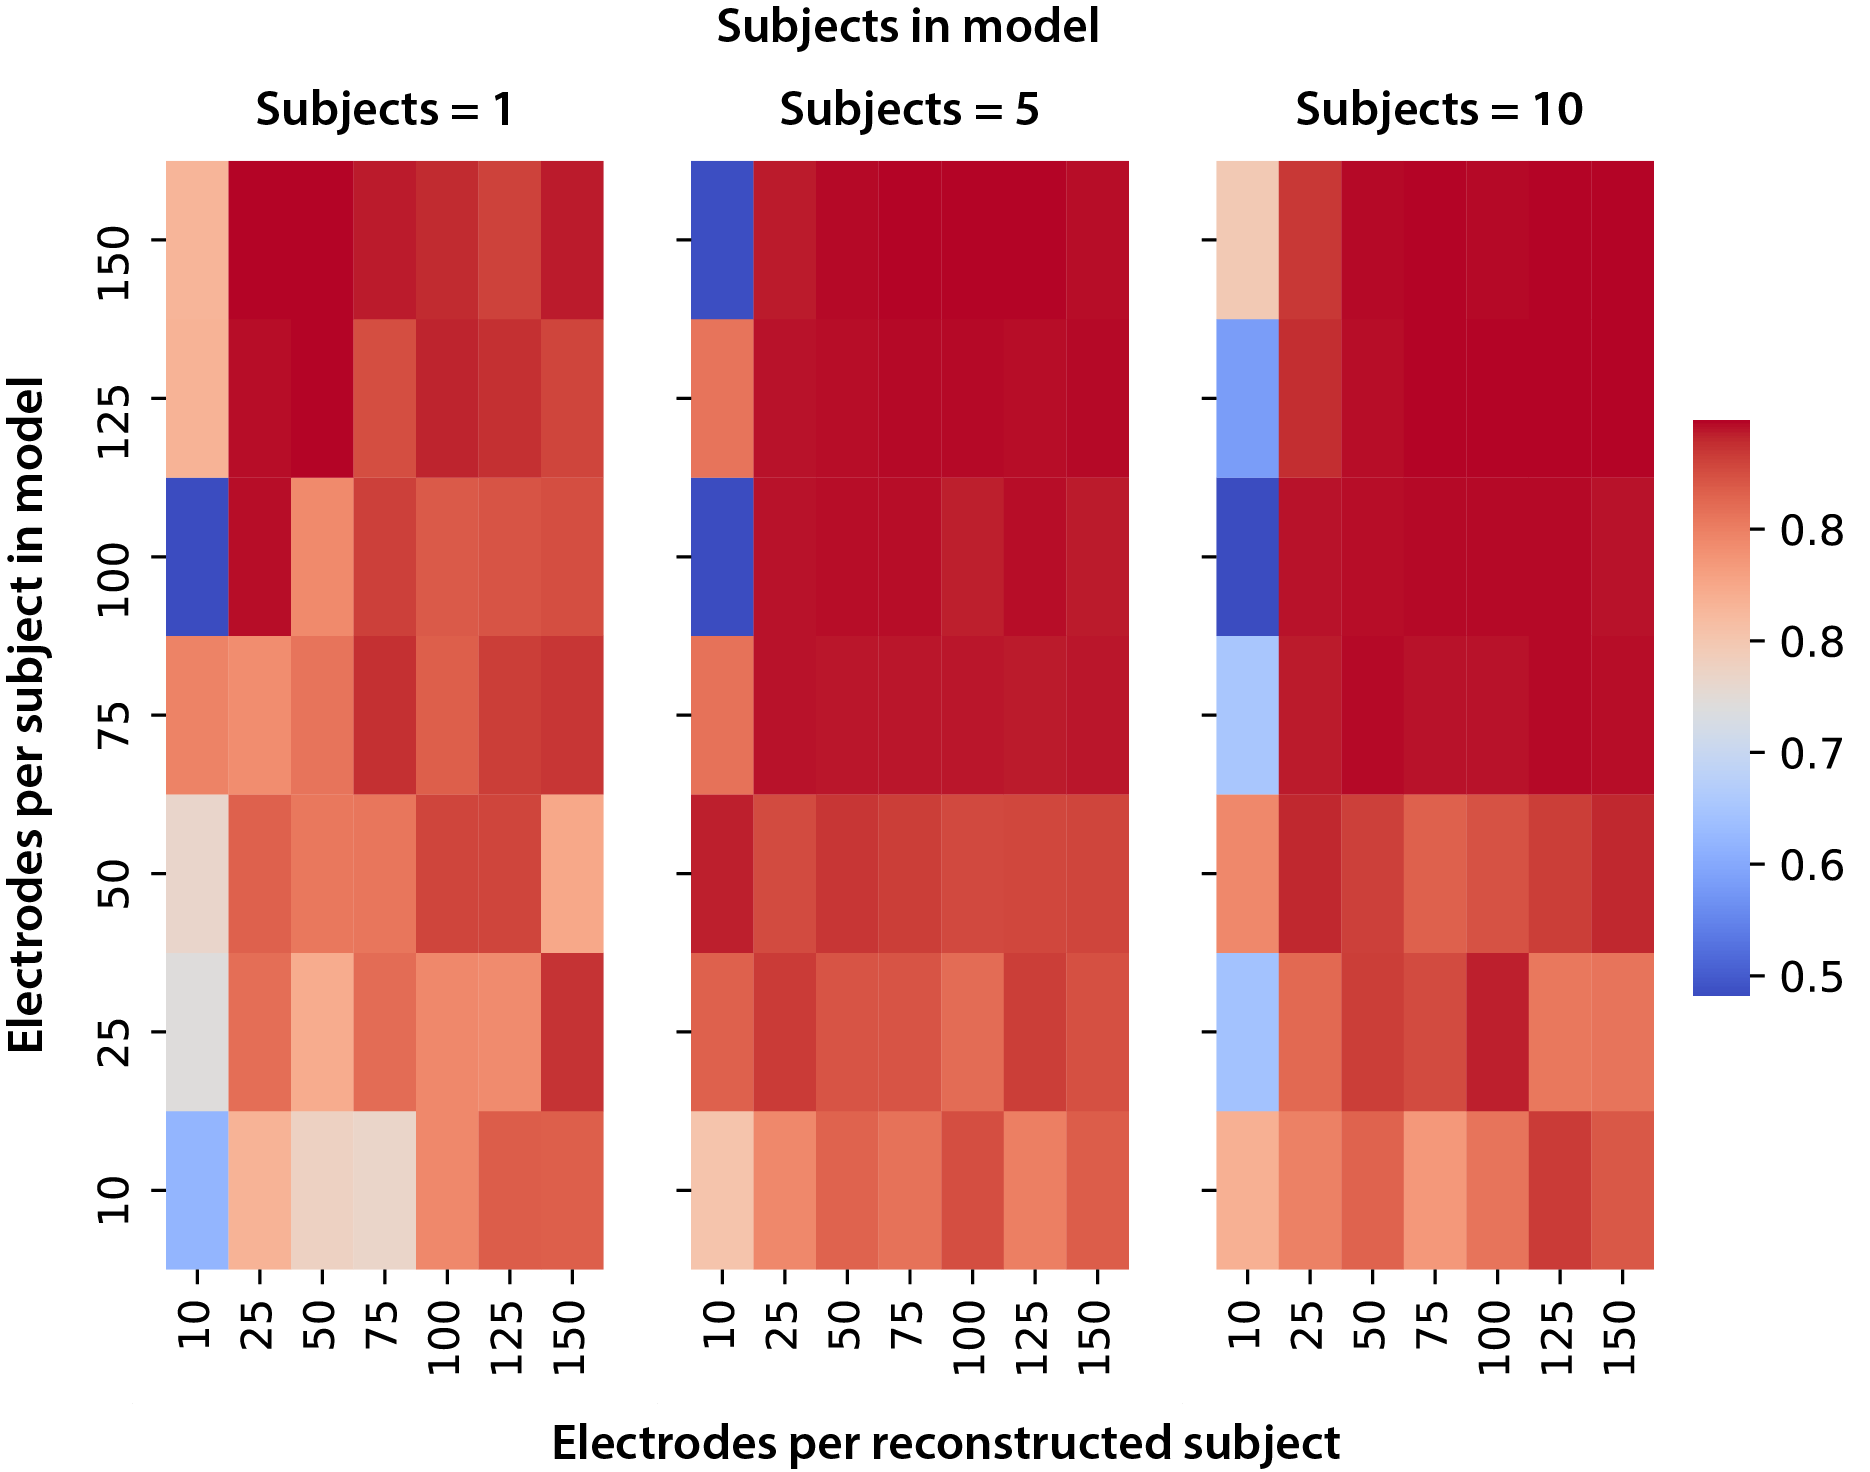

In [18]:
from IPython.display import Image
Image("../supereeg/docs/tutorial/simulation_for_nb.png")